In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('always')

In [3]:
import anndata
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scanpy as sc
import torch
from torch.autograd import Variable

from scbasset.utils import *
import scbasset.metrics as metrics
from scbasset.model_class import ModelClass
from scbasset.config import Config

### download data

### path to input data

In [4]:
start_directory = '../../'
# start_directory = ''
motif_fasta_folder = start_directory + 'data/download/Homo_sapiens_motif_fasta'

### Path to input data 

In [5]:
seq_len = 768
# type_data, file_name = 'multiome_example', 'pbmc_multiome'
type_data, file_name = 'TF_to_region', 'TF_to_region_hvg'
# type_data, file_name = 'TF_to_region', 'TF_to_region_marker_genes'

data_path = start_directory + 'data/' + type_data + '/processed/'

ad_file = data_path + file_name + '-' + str(seq_len) + '-ad.h5ad'
h5_file = data_path + file_name + '-' + str(seq_len) + '-train_val_test.h5'

### load the data and trained model

In [6]:
f = h5py.File(h5_file, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

# Split train-validation set
train_ids, val_ids, test_ids = f['train_ids'][:], f['val_ids'][:], f['test_ids'][:]

X = torch.FloatTensor(X)

n_TFs = Y.shape[1]
ic(n_TFs, Y.shape[0])

ic| n_TFs: 945, Y.shape[0]: 12835


(945, 12835)

In [7]:
# read h5ad file
ad = anndata.read_h5ad(ad_file)
ad

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 945 × 12835
    obs: 'TF', 'exp_id', 'cell_line', 'motif_model', 'n_genes'
    var: 'chr', 'start', 'end', 'n_cells'

In [8]:
# os.makedirs("../..", exist_ok=True)
print(torch.cuda.is_available())
device = "cuda"
if "cuda" in device and not torch.cuda.is_available():
    device = "cpu"
else:
    torch.cuda.set_device(1)

print(device)

True
cuda


In [9]:
config = Config()
config.h5_file = h5_file
config.bottleneck_size = 64
config.activation_fct = 'relu'
config.batch_size = 32
# config.model_name = 'scbasset'
config.model_name = 'tfbanformer'
config.num_heads = 8
config.num_transforms = 7
config.repeat = 4
config.tower_multiplier = 1.122

print(config)

Config(parser_args=None, out_dir='output', bottleneck=32, batch_size=32, learning_rate=0.01, epochs=1000, h5_file='../../data/TF_to_region/processed/TF_to_region_hvg-768-train_val_test.h5', model_name='tfbanformer', residual_model=False, activation_fct='relu', seq_length=1344, num_heads=8, repeat=4, num_transforms=7, cuda=2, logs='logs', weights=None, tower_multiplier=1.122)


In [10]:
# load model
dashboard_model = ModelClass(config, n_TFs=n_TFs)
dashboard_model.activate_analysis()
dashboard_model.load_data(h5_file, shuffle=False)
# dashboard_model.load_weights(device, best=0, trained_model_dir='output/scbasset/TF_to_region_hvg/32_1344_6_TL/')
dashboard_model.load_weights(device, best=0)
dashboard_model.get_model_summary()
model = dashboard_model.model
model.to(device)

ic| ch_dim: 407, t_x_dim: 16
ic| x_dim: 8
ic| self.n_TFs: 945, len(X_train): 11552, len(Y_train): 11552
ic| features.shape: torch.Size([32, 768, 4])
ic| trained_model_dir: 'output/tfbanformer/TF_to_region_hvg/64_768_4_8_7_32_relu_1-122/'
ic| self.model: TfBanformer(
                  (conv_block1): ConvBlock(
                    (nonLinear): ReLU()
                    (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
                    (conv_layer): Conv1d(4, 288, kernel_size=(17,), stride=(1,), padding=same, bias=False)
                    (maxpool_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
                  )
                  (conv_tower1): ConvTower(
                    (conv_blocks): ModuleList(
                      (0): ConvBlock(
                        (nonLinear): ReLU()
                        (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       

TfBanformer(
  (conv_block1): ConvBlock(
    (nonLinear): ReLU()
    (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv_layer): Conv1d(4, 288, kernel_size=(17,), stride=(1,), padding=same, bias=False)
    (maxpool_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_tower1): ConvTower(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (nonLinear): ReLU()
        (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 288, kernel_size=(5,), stride=(1,), padding=same, bias=False)
        (maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (nonLinear): ReLU()
        (bn_layer): BatchNorm1d(323, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 323, kernel_size=(5,), stride=(1,), padding=same

### score a TF of interest

In [11]:
df_pred, df_y = dashboard_model.predict_one(X, Y, item_id=0)

y_tf = df_y.index[df_y[0] == 1].tolist()
y_tf_f = df_y.index[df_y[0] == 0].tolist()
ic(df_pred.iloc[y_tf].max(), df_pred.iloc[y_tf].min())
ic(df_pred.iloc[y_tf_f].max(), df_pred.iloc[y_tf_f].min())
ic(df_y)

ic| df_pred.iloc[y_tf].max(): 0    0.011241
                              dtype: float32
    df_pred.iloc[y_tf].min(): 0    0.000088
                              dtype: float32
ic| df_pred.iloc[y_tf_f].max(): 0    0.085915
                                dtype: float32
    df_pred.iloc[y_tf_f].min(): 0    1.108170e-31
                                dtype: float32
ic| df_y:        0
          0    0.0
          1    0.0
          2    0.0
          3    0.0
          4    0.0
          ..   ...
          940  0.0
          941  0.0
          942  0.0
          943  0.0
          944  0.0
          
          [945 rows x 1 columns]


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
940,0.0
941,0.0
942,0.0
943,0.0


### Get Prediction for all regions

In [12]:
df_score, df_y = dashboard_model.predict_batch(dashboard_model.train_dataloader, sigmoid=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:08<00:00, 40.81batch/s]


#### Analysis of the predictions

In [13]:
df_score.head(25)

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
0,0.037092,0.118578,9.164774e-01,8.791439e-01,0.993394,9.847493e-01,0.001001,0.001944,0.004114,0.004051,...,3.882314e-01,0.998778,0.000189,0.000191,0.000216,0.000185,0.011759,0.009697,0.000695,3.096804e-08
1,0.271445,0.226328,5.521069e-03,1.783072e-03,0.098208,5.347602e-03,0.012985,0.069285,0.075489,0.051592,...,1.532529e-03,0.007953,0.000236,0.000519,0.000207,0.000228,0.122824,0.285860,0.033075,1.386548e-01
2,0.006092,0.027672,2.113029e-05,7.023556e-06,0.000094,7.530735e-05,0.000976,0.003335,0.004334,0.003655,...,9.149219e-08,0.000048,0.000899,0.000923,0.000826,0.000859,0.024238,0.006083,0.018742,1.016159e-05
3,0.056570,0.173935,7.185218e-01,7.335511e-01,0.948363,9.039787e-01,0.008713,0.020817,0.007857,0.006717,...,3.688579e-01,0.946504,0.004021,0.003910,0.004350,0.003971,0.059711,0.029662,0.012013,1.289555e-05
4,0.075450,0.101609,9.661961e-01,9.972928e-01,0.991295,9.994133e-01,0.001702,0.001745,0.090089,0.075761,...,7.637999e-01,0.998682,0.000330,0.000322,0.000351,0.000281,0.061256,0.029427,0.006553,1.571543e-04
5,0.038604,0.158872,6.476362e-04,1.408071e-04,0.008304,8.777475e-04,0.022906,0.031218,0.010615,0.008970,...,1.112739e-05,0.001741,0.012726,0.013712,0.013272,0.013435,0.091538,0.018719,0.062986,2.650171e-05
6,0.003200,0.030380,6.628308e-06,5.673105e-07,0.000073,5.646732e-06,0.000528,0.004376,0.000762,0.000733,...,1.609094e-08,0.000055,0.000188,0.000197,0.000178,0.000174,0.015220,0.004690,0.010924,6.385186e-07
7,0.005562,0.023713,4.849142e-06,1.185847e-06,0.000059,1.374385e-05,0.000377,0.001377,0.003192,0.002852,...,9.507783e-09,0.000035,0.000261,0.000277,0.000248,0.000244,0.016059,0.003931,0.011758,1.100513e-06
8,0.001948,0.016745,1.808556e-05,1.690992e-07,0.000074,2.314599e-05,0.075666,0.002236,0.000184,0.000200,...,2.023389e-09,0.000933,0.005343,0.005774,0.005041,0.005689,0.015829,0.001516,0.009072,6.407635e-08
9,0.001047,0.002953,9.765771e-06,9.198725e-06,0.000036,9.653557e-05,0.000020,0.000138,0.001094,0.000894,...,2.562053e-08,0.000065,0.000016,0.000014,0.000014,0.000012,0.005638,0.001874,0.003992,1.876080e-06


In [14]:
fpr, tpr, fnr, opt_threshold, threshold, roc_auc, result_roc = metrics.roc_curve_multilabel(df_score, df_y)

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [15]:
opt_threshold['micro']

0.03196079

In [16]:
sum = 0
for key in opt_threshold.keys():
    if key != 'micro':
        sum += opt_threshold[key]
sum / (len(opt_threshold.keys()) - 1)

0.041750005848748016

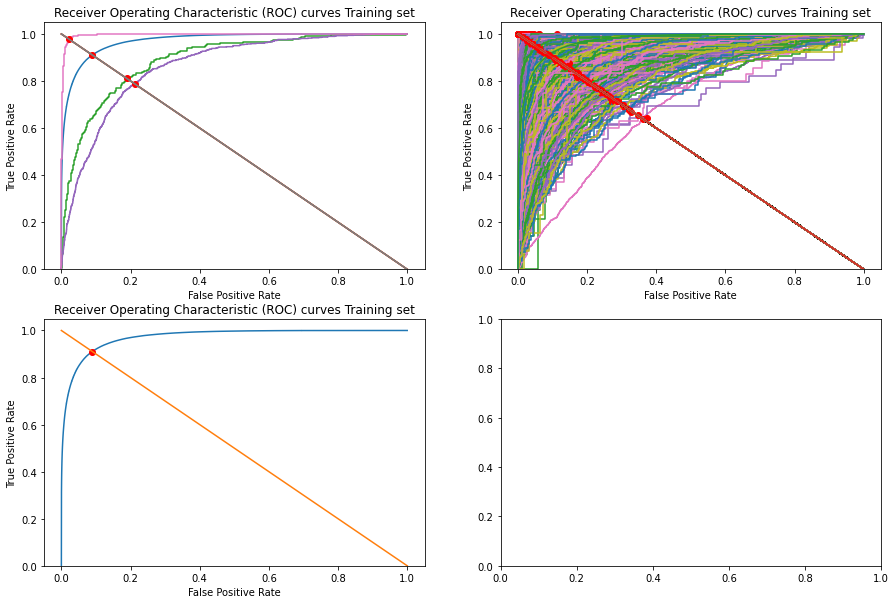

In [17]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[0][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[1][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr[0], tpr[0], axes[0][0], result_roc[0], "Training set")
metrics.plot_eer_roc(fpr[1], tpr[1], axes[0][0], result_roc[1], "Training set")
metrics.plot_eer_roc(fpr[2], tpr[2], axes[0][0], result_roc[2], "Training set")
for key in result_roc.keys():
    metrics.plot_eer_roc(fpr[key], tpr[key], axes[0][1], result_roc[key], "Training set")

In [18]:
print('TF bounded', df_y.T[df_y.T == 1].count().sum())
df_y.T[df_y.T == 1].count()

TF bounded 365903


0        149
1        143
2          0
3        162
4        205
        ... 
11547     22
11548     16
11549    100
11550    129
11551      4
Length: 11552, dtype: int64

In [19]:
df_pred = df_score.where(df_score > opt_threshold['micro'], other=0)
df_pred = df_pred.where(df_pred == 0, other=1)
df_pred

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11549,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
11550,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
results = df_y - df_pred
results

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
4,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
11548,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11549,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
11550,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


In [21]:
# bind_learned = tmp[tmp < 1].count().sum()
bind_not_learned = results.T[results.T > 0].count().sum()
unbind_learned = results.T[results.T == 0].count().sum()
unbind_not_learned = results.T[results.T < 0].count().sum()

# print('TF binding learned', bind_learned)
print('TF binding not learned', bind_not_learned)
print('TF (un)bounded learned', unbind_learned)
print('TF unbounded not learned', unbind_not_learned)
# print('total corresponds :', 12835*945 == bind_learned+bind_not_learned+unbind_learned+unbind_not_learned)

TF binding not learned 32711
TF (un)bounded learned 9940718
TF unbounded not learned 943211


In [22]:
ad.obs.value_counts('TF').head(65)

TF
CTCF     170
SPI1      46
MYC       44
RUNX1     36
GATA1     36
        ... 
CTCFL      3
NFIC       3
E2F6       3
BATF       3
EBF1       3
Length: 65, dtype: int64

## Score TFs

### Score total

In [23]:
df_total_scores = dashboard_model.contruct_auc_scores_by_TF(df_y, df_score, ad)
df_total_scores

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
0,0.889517,0.219871,281,FOXK2,K562_myelogenous_leukemia,MA1103.2
1,0.861560,0.296143,684,GATA3,Jurkat_T-cells,MA0037.3
2,0.996500,0.950037,645,CTCF,CD4_T-cells,MA0139.1
3,0.997978,0.973084,775,CTCF,ID00014_lymphoblastoid_cell_DiGeorge_syndrome,MA0139.1
4,0.996211,0.957103,863,CTCF,gm10847,MA0139.1
...,...,...,...,...,...,...
940,0.963145,0.424858,131,FOS,THP-1_acute_monocytic_leukemia,MA1134.1
941,0.798017,0.177482,611,TCF4,CAL-1_plasmacytoid_dendritic_neoplasm,MA0830.2
942,0.871797,0.195626,237,YY1,GM12892_female_B-cells_lymphoblastoid_cell_line,MA0095.2
943,0.790717,0.092892,309,BHLHE22,CAL-1_plasmacytoid_dendritic_neoplasm,MA0818.1


In [24]:
print('auc roc score : ', df_total_scores['auc_roc'].mean())
print('auc pr score : ', df_total_scores['auc_pr'].mean())

auc roc score :  0.9359323074781916
auc pr score :  0.4528439421006094


In [25]:
df_total_scores[df_total_scores['count_regions'] > 20].sort_values(by='auc_pr', ascending=False).head(10)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
278,0.999225,0.990314,811,CTCF,GM19193_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
597,0.999292,0.989421,706,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1
524,0.998863,0.987587,804,CTCF,GM18505_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
647,0.998885,0.987462,829,CTCF,GM19099_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
315,0.998910,0.987193,804,CTCF,GM10847_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
899,0.998900,0.987048,843,CTCF,GM18526_B__cells_Lymphoblastoid_Cell_Lines,MA0139.1
413,0.999158,0.986969,692,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
856,0.998800,0.986774,878,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1
742,0.999013,0.986385,741,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1
80,0.998813,0.986309,844,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1


In [26]:
df_total_scores[df_total_scores['TF'].isin(['PAX5', 'EBF1'])].sort_values(by='auc_pr', ascending=False).head(25)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
85,0.966121,0.642155,542,PAX5,GM12892_female_B-cells_lymphoblastoid_cell_line,MA0014.3
724,0.901728,0.523455,833,PAX5,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0014.3
728,0.927600,0.315012,304,PAX5,GM12891_male_B-_cells_lymphoblastoid_cell_line,MA0014.3
250,0.815937,0.297468,992,EBF1,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0154.4
198,0.876018,0.181266,219,PAX5,L428_Hodgkin_lymphoma,MA0014.3
648,0.858769,0.152686,288,EBF1,LCL_lymphoblastoid_cell_line,MA0154.4
96,0.817304,0.102566,224,EBF1,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0154.4
78,0.827485,0.096235,142,PAX5,Namalwa_Burkitt_lymphoma,MA0014.3
825,0.759144,0.052280,115,PAX5,Raji_Burkitt_lymphoma,MA0014.3
741,0.846483,0.046291,12,PAX5,DOHH2_diffuse_large_B-cell_lymphoma,MA0014.3


In [27]:
tmp = df_pred[[724, 96, 250]]
tmp[['PAX5', "EBF1", "EBF1_"]] = df_y[[724, 96, 250]]
tmp.loc[(tmp[724] == 1) & (tmp[96] == 1) & (tmp['PAX5'] == 1) & (tmp["EBF1"] == 1)].head(10)

/local_scratch/tmp-vsc34619/ipykernel_76987/880161388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['PAX5', "EBF1", "EBF1_"]] = df_y[[724, 96, 250]]
/local_scratch/tmp-vsc34619/ipykernel_76987/880161388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['PAX5', "EBF1", "EBF1_"]] = df_y[[724, 96, 250]]
/local_scratch/tmp-vsc34619/ipykernel_76987/880161388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,724,96,250,PAX5,EBF1,EBF1_
1078,1.0,1.0,1.0,1.0,1.0,1.0
1177,1.0,1.0,1.0,1.0,1.0,1.0
1229,1.0,1.0,1.0,1.0,1.0,1.0
1444,1.0,1.0,1.0,1.0,1.0,1.0
1530,1.0,1.0,1.0,1.0,1.0,1.0
1946,1.0,1.0,1.0,1.0,1.0,1.0
2232,1.0,1.0,1.0,1.0,1.0,1.0
2500,1.0,1.0,1.0,1.0,1.0,1.0
2788,1.0,1.0,1.0,1.0,1.0,1.0
3519,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
df_total_scores[df_total_scores['TF'].isin(['GATA1'])].sort_values(by='auc_pr', ascending=False).head(10)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
715,0.968536,0.574273,163,GATA1,K562_myelogenous_leukemia,MA0035.4
455,0.935824,0.556306,247,GATA1,CD36_erythroid_cells,MA0035.4
9,0.943663,0.550696,215,GATA1,CD36_erythroid_cells,MA0035.4
454,0.927402,0.546475,251,GATA1,CD36_erythroid_cells,MA0140.2
683,0.924590,0.526767,121,GATA1,CD34_cells_ERYTH_BMP,MA0035.4
460,0.990436,0.525243,48,GATA1,K562_myelogenous_leukemia,MA0140.2
8,0.942426,0.523632,232,GATA1,CD36_erythroid_cells,MA0140.2
720,0.937471,0.522084,183,GATA1,K562_myelogenous_leukemia,MA0035.4
22,0.889507,0.516417,439,GATA1,K562_myelogenous_leukemia,MA0035.4
721,0.935285,0.512957,183,GATA1,K562_myelogenous_leukemia,MA0140.2


In [29]:
tmp = df_pred[[715]]
tmp[['GATA1']] = df_y[[715]]
tmp.loc[(tmp[715] == 1) & (tmp['GATA1'] == 1)].head(10)

/local_scratch/tmp-vsc34619/ipykernel_76987/3600595362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['GATA1']] = df_y[[715]]


,715,GATA1
25,1.0,1.0
33,1.0,1.0
51,1.0,1.0
92,1.0,1.0
112,1.0,1.0
153,1.0,1.0
244,1.0,1.0
315,1.0,1.0
356,1.0,1.0
372,1.0,1.0


In [30]:
df_total_scores[df_total_scores['TF'].isin(['SPI1'])].sort_values(by='auc_pr', ascending=False).head(10)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
55,0.986757,0.888342,940,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
581,0.991099,0.886646,673,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
643,0.988774,0.883172,793,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
762,0.989210,0.882909,732,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
330,0.981164,0.882063,1010,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
276,0.987483,0.880808,860,SPI1,MDMmonocyte_derived_macrophages,MA0080.5
379,0.987519,0.879652,855,SPI1,MDMmonocyte_derived_macrophages,MA0080.5
582,0.990637,0.877476,683,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
370,0.985984,0.876925,903,SPI1,MDMmonocyte_derived_macrophages,MA0080.5
804,0.985485,0.876093,900,SPI1,MDMmonocyte_derived_macrophages,MA0080.5


In [31]:
tmp = df_pred[[55]]
tmp[['SPI1']] = df_y[[55]]
tmp.loc[(tmp[55] == 1) & (tmp['SPI1'] == 1)].head(10)

/local_scratch/tmp-vsc34619/ipykernel_76987/1522220181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['SPI1']] = df_y[[55]]


,55,SPI1
10,1.0,1.0
13,1.0,1.0
16,1.0,1.0
21,1.0,1.0
29,1.0,1.0
32,1.0,1.0
33,1.0,1.0
35,1.0,1.0
54,1.0,1.0
69,1.0,1.0


In [32]:
df_total_scores[df_total_scores['TF'].isin(['CTCF'])].sort_values(by='auc_pr', ascending=False).head(10)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
278,0.999225,0.990314,811,CTCF,GM19193_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
597,0.999292,0.989421,706,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1
524,0.998863,0.987587,804,CTCF,GM18505_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
647,0.998885,0.987462,829,CTCF,GM19099_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
315,0.998910,0.987193,804,CTCF,GM10847_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
899,0.998900,0.987048,843,CTCF,GM18526_B__cells_Lymphoblastoid_Cell_Lines,MA0139.1
413,0.999158,0.986969,692,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
856,0.998800,0.986774,878,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1
742,0.999013,0.986385,741,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1
80,0.998813,0.986309,844,CTCF,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0139.1


In [33]:
tmp = df_pred[[278]]
tmp[['CTCF']] = df_y[[278]]
tmp.loc[(tmp[278] == 1) & (tmp['CTCF'] == 1)].head(10)

/local_scratch/tmp-vsc34619/ipykernel_76987/1452038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['CTCF']] = df_y[[278]]


,278,CTCF
0,1.0,1.0
3,1.0,1.0
4,1.0,1.0
14,1.0,1.0
51,1.0,1.0
67,1.0,1.0
78,1.0,1.0
115,1.0,1.0
122,1.0,1.0
140,1.0,1.0


### Validation set

In [34]:
# df_val_pred, df_val_y = dashboard_model.predict_all(X[val_ids], Y[val_ids])
df_val_score, df_val_y = dashboard_model.predict_batch(dashboard_model.val_dataloader, sigmoid=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 81.66batch/s]


In [103]:
fpr, tpr, fnr, opt_threshold, threshold, roc_auc, result_roc = metrics.roc_curve_multilabel(df_val_score, df_val_y)

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/sta

In [104]:
opt_threshold['micro']

0.012361061

In [105]:
sum = 0
for key in opt_threshold.keys():
    if key != 'micro':
        sum += opt_threshold[key]
sum / (len(opt_threshold.keys()) - 1)

0.01652593464173944

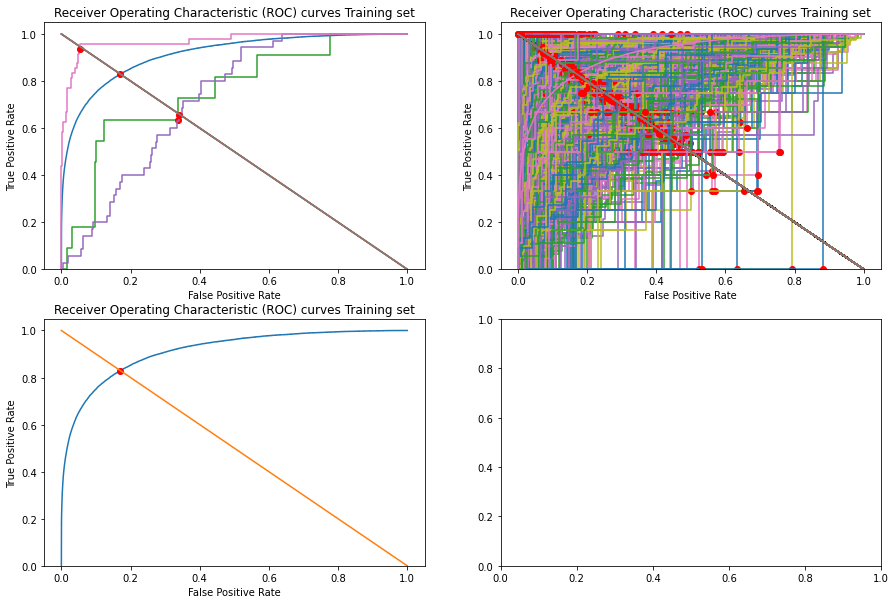

In [106]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[0][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[1][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr[0], tpr[0], axes[0][0], result_roc[0], "Training set")
metrics.plot_eer_roc(fpr[1], tpr[1], axes[0][0], result_roc[1], "Training set")
metrics.plot_eer_roc(fpr[2], tpr[2], axes[0][0], result_roc[2], "Training set")
for key in result_roc.keys():
    metrics.plot_eer_roc(fpr[key], tpr[key], axes[0][1], result_roc[key], "Training set")

In [107]:
# df_val_y = df_y.iloc[val_ids]
# df_val_pred = df_pred.iloc[val_ids]
df_val_scores = dashboard_model.contruct_auc_scores_by_TF(df_val_y, df_val_score, ad)

In [108]:
import scipy.stats as st
st.norm.interval(alpha=0.99, loc=np.mean(df_val_scores['auc_pr']), scale=st.sem(df_val_scores['auc_pr']))

(0.25072407315235906, 0.2990389877757437)

In [109]:
percentile = 99
low_99 = round(len(df_val_scores[df_val_scores['count_regions'] > 0])*(100-percentile)/2/100)
up_99 = round(len(df_val_scores[df_val_scores['count_regions'] > 0])*(percentile + (100-percentile)/2)/100)
print('auc roc score : ', df_val_scores[df_val_scores['count_regions'] > 0]['auc_roc'][low_99:up_99+1].mean())
print('auc pr score : ', df_val_scores[df_val_scores['count_regions'] > 0]['auc_pr'][low_99:up_99+1].mean())

auc roc score :  0.8364660510548825
auc pr score :  0.29733734613675233


In [110]:
df_val_pred = df_val_score.where(df_val_score > opt_threshold['micro'], other=0)
df_val_pred = df_val_pred.where(df_val_pred == 0, other=1)
df_val_pred

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
637,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [111]:
df_val_scores[df_val_scores['count_regions'] > 9].sort_values(by='auc_pr', ascending=False)[:10]

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
471,0.985293,0.910216,42,CTCF,THP-1_acute_monocytic_leukemia,MA0139.1
408,0.983184,0.885963,51,CTCF,thyroid_gland,MA0139.1
281,0.973945,0.881683,51,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
522,0.983416,0.881370,47,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
278,0.974664,0.879905,52,CTCF,GM19193_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
590,0.979869,0.874262,48,CTCF,spleen,MA0139.1
570,0.969876,0.872878,47,CTCF,KMS-11_Plasma_cell_myeloma,MA0139.1
324,0.971955,0.872584,53,CTCF,OCI-LY7_diffuse_large_B-cell_lymphoma,MA0139.1
413,0.977225,0.870758,50,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
647,0.974176,0.867193,56,CTCF,GM19099_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1


In [112]:
df_val_scores[df_val_scores['TF'].isin(['PAX5', 'EBF1'])].sort_values(by='auc_pr', ascending=False).head(25)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
85,0.920654,0.547574,33,PAX5,GM12892_female_B-cells_lymphoblastoid_cell_line,MA0014.3
724,0.803045,0.334750,42,PAX5,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0014.3
728,0.840403,0.224249,17,PAX5,GM12891_male_B-_cells_lymphoblastoid_cell_line,MA0014.3
250,0.705589,0.204994,64,EBF1,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0154.4
198,0.813914,0.171261,17,PAX5,L428_Hodgkin_lymphoma,MA0014.3
96,0.673589,0.082199,15,EBF1,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0154.4
78,0.598950,0.052490,6,PAX5,Namalwa_Burkitt_lymphoma,MA0014.3
648,0.585463,0.043839,19,EBF1,LCL_lymphoblastoid_cell_line,MA0154.4
825,0.579790,0.013444,6,PAX5,Raji_Burkitt_lymphoma,MA0014.3
482,0.483804,0.007150,3,PAX5,OCI-LY7_diffuse_large_B-cell_lymphoma,MA0014.3


In [113]:
tmp = df_val_pred[[85, 250, 724]]
tmp[['PAX5', "EBF1", "PAX5_"]] = df_val_y[[85, 250, 724]]
tmp.loc[(tmp[85] == 1) & (tmp[250] == 1) & (tmp['PAX5'] == 1) & (tmp["EBF1"] == 1)].head(20)

/local_scratch/tmp-vsc34619/ipykernel_76987/3090599439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['PAX5', "EBF1", "PAX5_"]] = df_val_y[[85, 250, 724]]
/local_scratch/tmp-vsc34619/ipykernel_76987/3090599439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['PAX5', "EBF1", "PAX5_"]] = df_val_y[[85, 250, 724]]
/local_scratch/tmp-vsc34619/ipykernel_76987/3090599439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,85,250,724,PAX5,EBF1,PAX5_
19,1.0,1.0,1.0,1.0,1.0,1.0
114,1.0,1.0,1.0,1.0,1.0,1.0
176,1.0,1.0,1.0,1.0,1.0,1.0
232,1.0,1.0,1.0,1.0,1.0,1.0
252,1.0,1.0,1.0,1.0,1.0,1.0
293,1.0,1.0,1.0,1.0,1.0,0.0
530,1.0,1.0,1.0,1.0,1.0,1.0
560,1.0,1.0,1.0,1.0,1.0,1.0


In [114]:
test_scores = df_val_scores[df_val_scores['TF'].isin(['GATA1'])].sort_values(by='auc_pr', ascending=False).head(10)
index_ = test_scores.index[0]
test_scores

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
298,0.652291,0.137495,43,GATA1,CD34_cells,MA0035.4
8,0.944570,0.136132,7,GATA1,CD36_erythroid_cells,MA0140.2
539,0.914316,0.133766,3,GATA1,CD34_cells_ERYTH_BIO,MA0035.4
683,0.930512,0.130352,3,GATA1,CD34_cells_ERYTH_BMP,MA0035.4
9,0.922938,0.108821,7,GATA1,CD36_erythroid_cells,MA0035.4
343,0.629143,0.076655,26,GATA1,CD34_bone_marrow_cell-derived_erythroid_progen...,MA0140.2
342,0.634792,0.075699,24,GATA1,CD34_bone_marrow_cell-derived_erythroid_progen...,MA0035.4
816,0.751960,0.069220,13,GATA1,erythroblasts,MA0035.4
135,0.662058,0.064270,21,GATA1,K562_myelogenous_leukemia,MA0035.4
774,0.863452,0.063549,7,GATA1,CD34_hematopoietic_stem_cells-derived_proeryth...,MA0035.4


In [115]:
tmp = df_val_pred[[index_]]
tmp[['GATA1']] = df_val_y[[index_]]
tmp.loc[(tmp[index_] == 1) & (tmp['GATA1'] == 1)].head(20)

/local_scratch/tmp-vsc34619/ipykernel_76987/4036679367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['GATA1']] = df_val_y[[index_]]


,298,GATA1
20,1.0,1.0
28,1.0,1.0
33,1.0,1.0
81,1.0,1.0
92,1.0,1.0
106,1.0,1.0
111,1.0,1.0
161,1.0,1.0
164,1.0,1.0
165,1.0,1.0


In [116]:
df_val_scores[df_val_scores['TF'].isin(['SPI1'])].sort_values(by='auc_pr', ascending=False).head(10)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
762,0.950247,0.704186,47,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
543,0.884526,0.702814,135,SPI1,macrophages_IL4,MA0080.5
187,0.896619,0.695293,107,SPI1,macrophages_TPP,MA0080.5
55,0.943313,0.670356,57,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
330,0.941779,0.668508,62,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
643,0.952220,0.662055,48,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
581,0.966621,0.661002,36,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
804,0.946540,0.656499,55,SPI1,MDMmonocyte_derived_macrophages,MA0080.5
781,0.869212,0.650866,123,SPI1,macrophages_IFNG,MA0080.5
379,0.956730,0.650587,47,SPI1,MDMmonocyte_derived_macrophages,MA0080.5


In [117]:
tmp = df_val_pred[[55]]
tmp[['SPI1']] = df_val_y[[55]]
tmp.loc[(tmp[55] == 1) & (tmp['SPI1'] == 1)].head(20)

/local_scratch/tmp-vsc34619/ipykernel_76987/3463964265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['SPI1']] = df_val_y[[55]]


,55,SPI1
4,1.0,1.0
11,1.0,1.0
18,1.0,1.0
34,1.0,1.0
48,1.0,1.0
55,1.0,1.0
61,1.0,1.0
83,1.0,1.0
89,1.0,1.0
98,1.0,1.0


In [118]:
df_val_scores[df_val_scores['TF'].isin(['CTCF'])].sort_values(by='auc_pr', ascending=False).head(10)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
471,0.985293,0.910216,42,CTCF,THP-1_acute_monocytic_leukemia,MA0139.1
408,0.983184,0.885963,51,CTCF,thyroid_gland,MA0139.1
281,0.973945,0.881683,51,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
522,0.983416,0.881370,47,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
278,0.974664,0.879905,52,CTCF,GM19193_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
590,0.979869,0.874262,48,CTCF,spleen,MA0139.1
570,0.969876,0.872878,47,CTCF,KMS-11_Plasma_cell_myeloma,MA0139.1
324,0.971955,0.872584,53,CTCF,OCI-LY7_diffuse_large_B-cell_lymphoma,MA0139.1
413,0.977225,0.870758,50,CTCF,MDMmonocyte_derived_macrophages,MA0139.1
647,0.974176,0.867193,56,CTCF,GM19099_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1


In [119]:
tmp = df_val_pred[[278]]
tmp[['CTCF']] = df_val_y[[278]]
tmp.loc[(tmp[278] == 1) & (tmp['CTCF'] == 1)].head(10)

/local_scratch/tmp-vsc34619/ipykernel_76987/109668650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['CTCF']] = df_val_y[[278]]


,278,CTCF
20,1.0,1.0
36,1.0,1.0
44,1.0,1.0
67,1.0,1.0
70,1.0,1.0
82,1.0,1.0
100,1.0,1.0
111,1.0,1.0
120,1.0,1.0
176,1.0,1.0


### Test set

In [123]:
# df_test_pred, df_test_y = dashboard_model.predict_all(X[test_ids], Y[test_ids])
df_test_score, df_test_y = dashboard_model.predict_batch(dashboard_model.test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 79.54batch/s]


In [124]:
fpr, tpr, fnr, opt_threshold, threshold, roc_auc, result_roc = metrics.roc_curve_multilabel(df_test_score, df_test_y)

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/sta

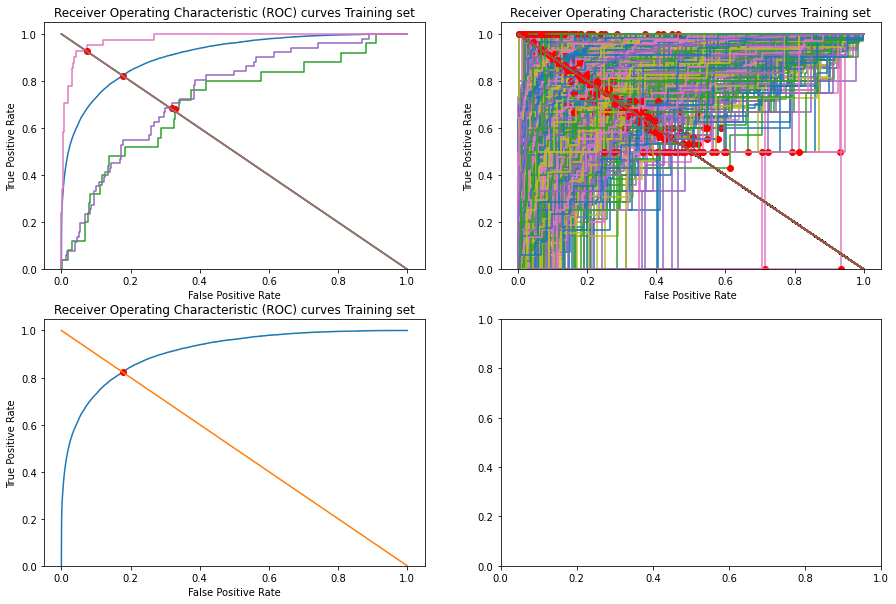

In [125]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[0][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[1][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr[0], tpr[0], axes[0][0], result_roc[0], "Training set")
metrics.plot_eer_roc(fpr[1], tpr[1], axes[0][0], result_roc[1], "Training set")
metrics.plot_eer_roc(fpr[2], tpr[2], axes[0][0], result_roc[2], "Training set")
for key in result_roc.keys():
    metrics.plot_eer_roc(fpr[key], tpr[key], axes[0][1], result_roc[key], "Training set")

In [126]:
df_test_scores = dashboard_model.contruct_auc_scores_by_TF(df_test_y, df_test_score, ad)
df_test_scores

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
0,0.705932,0.107685,25,FOXK2,K562_myelogenous_leukemia,MA1103.2
1,0.745496,0.213939,51,GATA3,Jurkat_T-cells,MA0037.3
2,0.980358,0.829817,41,CTCF,CD4_T-cells,MA0139.1
3,0.976665,0.764115,44,CTCF,ID00014_lymphoblastoid_cell_DiGeorge_syndrome,MA0139.1
4,0.942756,0.709018,53,CTCF,gm10847,MA0139.1
...,...,...,...,...,...,...
940,0.712264,0.063130,6,FOS,THP-1_acute_monocytic_leukemia,MA1134.1
941,0.716080,0.145527,36,TCF4,CAL-1_plasmacytoid_dendritic_neoplasm,MA0830.2
942,0.799221,0.106980,16,YY1,GM12892_female_B-cells_lymphoblastoid_cell_line,MA0095.2
943,0.709176,0.065260,17,BHLHE22,CAL-1_plasmacytoid_dendritic_neoplasm,MA0818.1


In [127]:
st.norm.interval(alpha=0.99, loc=np.mean(df_test_scores['auc_pr']), scale=st.sem(df_test_scores['auc_pr']))

(0.2623514320338272, 0.30924594438609415)

In [128]:
percentile = 99
low_99 = round(len(df_test_scores[df_test_scores['count_regions'] > 0])*(100-percentile)/2/100)
up_99 = round(len(df_test_scores[df_test_scores['count_regions'] > 0])*(percentile + (100-percentile)/2)/100)
print('auc roc score : ', df_test_scores[df_test_scores['count_regions'] > 0]['auc_roc'][low_99:up_99+1].mean())
print('auc pr score : ', df_test_scores[df_test_scores['count_regions'] > 0]['auc_pr'][low_99:up_99+1].mean())

auc roc score :  0.8412152935929521
auc pr score :  0.3043392943947707


In [130]:
df_test_pred = df_test_score.where(df_test_score > opt_threshold['micro'], other=0)
df_test_pred = df_test_pred.where(df_test_pred == 0, other=1)
df_test_pred

,0,1,2,3,4,5,6,7,8,9,...,935,936,937,938,939,940,941,942,943,944
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
640,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [131]:
df_test_scores[df_test_scores['count_regions'] > 20].sort_values(by='auc_pr', ascending=False).head(25)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
5,0.983176,0.900944,50,CTCF,NB4_acute_promyelocytic_leukemia_,MA0139.1
836,0.976305,0.876168,55,CTCF,K562_myelogenous_leukemia,MA0139.1
86,0.979351,0.873106,49,CTCF,GM18486_Lymphoblastoid_Cell_Lines,MA0139.1
590,0.973130,0.870015,44,CTCF,spleen,MA0139.1
647,0.975148,0.866031,47,CTCF,GM19099_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
644,0.977008,0.865137,51,CTCF,K562_myelogenous_leukemia,MA0139.1
806,0.976103,0.858416,53,CTCF,THP-1_acute_monocytic_leukemia,MA0139.1
442,0.973682,0.858385,63,CTCF,GM12869_female_B-cells,MA0139.1
202,0.974796,0.852364,46,CTCF,OCI-LY7_diffuse_large_B-cell_lymphoma,MA0139.1
907,0.973044,0.850841,52,CTCF,THP-1_acute_monocytic_leukemia,MA0139.1


In [132]:
df_test_scores[df_test_scores['TF'].isin(['PAX5', 'EBF1'])].sort_values(by='auc_pr', ascending=False).head(25)

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
85,0.968793,0.591682,35,PAX5,GM12892_female_B-cells_lymphoblastoid_cell_line,MA0014.3
724,0.845622,0.359047,44,PAX5,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0014.3
250,0.794166,0.303384,58,EBF1,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0154.4
78,0.800158,0.208151,10,PAX5,Namalwa_Burkitt_lymphoma,MA0014.3
728,0.888188,0.202265,17,PAX5,GM12891_male_B-_cells_lymphoblastoid_cell_line,MA0014.3
198,0.807439,0.178876,14,PAX5,L428_Hodgkin_lymphoma,MA0014.3
648,0.733209,0.097485,19,EBF1,LCL_lymphoblastoid_cell_line,MA0154.4
825,0.964063,0.080556,2,PAX5,Raji_Burkitt_lymphoma,MA0014.3
96,0.678150,0.054477,15,EBF1,GM12878_female_B-cells_lymphoblastoid_cell_line,MA0154.4
482,0.173437,0.002748,2,PAX5,OCI-LY7_diffuse_large_B-cell_lymphoma,MA0014.3


In [133]:
tmp = df_test_pred[[85, 250, 724]]
tmp[['PAX5', 'EBF1', 'PAX5_']] = df_test_y[[85, 250, 724]]
tmp.loc[(tmp[724] == 1) & (tmp[250] == 1) & (tmp['PAX5_'] == 1) & (tmp["EBF1"] == 1)].head(20)

/local_scratch/tmp-vsc34619/ipykernel_76987/2835537680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['PAX5', 'EBF1', 'PAX5_']] = df_test_y[[85, 250, 724]]
/local_scratch/tmp-vsc34619/ipykernel_76987/2835537680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['PAX5', 'EBF1', 'PAX5_']] = df_test_y[[85, 250, 724]]
/local_scratch/tmp-vsc34619/ipykernel_76987/2835537680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,85,250,724,PAX5,EBF1,PAX5_
36,1.0,1.0,1.0,1.0,1.0,1.0
40,1.0,1.0,1.0,0.0,1.0,1.0
48,0.0,1.0,1.0,0.0,1.0,1.0
90,1.0,1.0,1.0,0.0,1.0,1.0
91,1.0,1.0,1.0,1.0,1.0,1.0
114,1.0,1.0,1.0,0.0,1.0,1.0
131,1.0,1.0,1.0,1.0,1.0,1.0
133,0.0,1.0,1.0,0.0,1.0,1.0
179,1.0,1.0,1.0,1.0,1.0,1.0
215,1.0,1.0,1.0,1.0,1.0,1.0


In [140]:
test_scores = df_test_scores[df_test_scores['TF'].isin(['GATA1'])].sort_values(by='auc_pr', ascending=False).head(10)
index_ = test_scores.index[3]
test_scores

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
921,0.820472,0.182436,7,GATA1,K562_myelogenous_leukemia,MA0140.2
715,0.799164,0.158458,11,GATA1,K562_myelogenous_leukemia,MA0035.4
920,0.827897,0.111728,7,GATA1,K562_myelogenous_leukemia,MA0035.4
298,0.555083,0.104631,54,GATA1,CD34_cells,MA0035.4
135,0.640444,0.103890,33,GATA1,K562_myelogenous_leukemia,MA0035.4
22,0.653659,0.093961,27,GATA1,K562_myelogenous_leukemia,MA0035.4
21,0.629537,0.089577,28,GATA1,K562_myelogenous_leukemia,MA0140.2
342,0.618736,0.073997,30,GATA1,CD34_bone_marrow_cell-derived_erythroid_progen...,MA0035.4
343,0.595425,0.073904,30,GATA1,CD34_bone_marrow_cell-derived_erythroid_progen...,MA0140.2
625,0.833680,0.072493,13,GATA1,primary_erythroblasts,MA0035.4


In [141]:
tmp = df_test_pred[[index_]]
tmp[['GATA1']] = df_test_y[[index_]]
tmp.loc[(tmp[index_] == 1) & (tmp['GATA1'] == 1)].head(20)

/local_scratch/tmp-vsc34619/ipykernel_76987/1832730064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['GATA1']] = df_test_y[[index_]]


,298,GATA1
1,1.0,1.0
2,1.0,1.0
18,1.0,1.0
27,1.0,1.0
35,1.0,1.0
53,1.0,1.0
62,1.0,1.0
80,1.0,1.0
90,1.0,1.0
122,1.0,1.0


In [142]:
test_scores = df_test_scores[df_test_scores['TF'].isin(['SPI1'])].sort_values(by='auc_pr', ascending=False).head(10)
index_ = test_scores.index[1]
test_scores

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
581,0.977035,0.767149,36,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
526,0.960851,0.765027,51,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
582,0.971549,0.763829,38,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
379,0.968417,0.759976,44,SPI1,MDMmonocyte_derived_macrophages,MA0080.5
209,0.975474,0.759030,34,SPI1,monocyte-derived_macrophages,MA0080.5
276,0.966960,0.751530,43,SPI1,MDMmonocyte_derived_macrophages,MA0080.5
571,0.998437,0.750000,2,SPI1,K562_myelogenous_leukemia,MA0080.5
643,0.968135,0.740140,42,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
456,0.960826,0.735078,46,SPI1,THP-1_acute_monocytic_leukemia,MA0080.5
370,0.960182,0.734681,49,SPI1,MDMmonocyte_derived_macrophages,MA0080.5


In [143]:
tmp = df_test_pred[[index_]]
tmp[['SPI1']] = df_test_y[[index_]]
tmp.loc[(tmp[index_] == 1) & (tmp['SPI1'] == 1)].head(20)

/local_scratch/tmp-vsc34619/ipykernel_76987/1803558340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['SPI1']] = df_test_y[[index_]]


,526,SPI1
18,1.0,1.0
31,1.0,1.0
46,1.0,1.0
56,1.0,1.0
71,1.0,1.0
73,1.0,1.0
75,1.0,1.0
90,1.0,1.0
107,1.0,1.0
133,1.0,1.0


In [144]:
test_scores = df_test_scores[df_test_scores['TF'].isin(['CTCF'])].sort_values(by='auc_pr', ascending=False).head(10)
index_ = test_scores.index[0]
test_scores

,auc_roc,auc_pr,count_regions,TF,cell_line,motif_model
5,0.983176,0.900944,50,CTCF,NB4_acute_promyelocytic_leukemia_,MA0139.1
836,0.976305,0.876168,55,CTCF,K562_myelogenous_leukemia,MA0139.1
86,0.979351,0.873106,49,CTCF,GM18486_Lymphoblastoid_Cell_Lines,MA0139.1
590,0.973130,0.870015,44,CTCF,spleen,MA0139.1
647,0.975148,0.866031,47,CTCF,GM19099_female_B-cells_Lymphoblastoid_Cell_Lines,MA0139.1
644,0.977008,0.865137,51,CTCF,K562_myelogenous_leukemia,MA0139.1
806,0.976103,0.858416,53,CTCF,THP-1_acute_monocytic_leukemia,MA0139.1
442,0.973682,0.858385,63,CTCF,GM12869_female_B-cells,MA0139.1
202,0.974796,0.852364,46,CTCF,OCI-LY7_diffuse_large_B-cell_lymphoma,MA0139.1
907,0.973044,0.850841,52,CTCF,THP-1_acute_monocytic_leukemia,MA0139.1


In [145]:
tmp = df_test_pred[[index_]]
tmp[['CTCF']] = df_test_y[[index_]]
tmp.loc[(tmp[index_] == 1) & (tmp['CTCF'] == 1)].head(10)

/local_scratch/tmp-vsc34619/ipykernel_76987/89309568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[['CTCF']] = df_test_y[[index_]]


,5,CTCF
9,1.0,1.0
15,1.0,1.0
24,1.0,1.0
95,1.0,1.0
99,1.0,1.0
110,1.0,1.0
124,1.0,1.0
129,1.0,1.0
131,1.0,1.0
150,1.0,1.0
